# Data Masters Case: Exploração inicial

Felipe Viacava -- São Paulo, ago/2023

Este documento contém a exploração de uma amostra de 80% da base inicial. Aqui, nenhuma modelagem foi realizada -- apenas uma análise exploratória para o problema de classificação do enunciado do case. A modelagem em si se encontra no documento "02-class.ipynb" deste diretório. Além disso, nenhuma alteração permanente foi realizada aqui; a análise foi realizada para criar e validar transformadores customizados e decidir quais seriam os _steps_ de cada pipeline de classificação testado.

## Bibliotecas

In [1]:
# --- Data Exploration --- #
import pandas as pd
import missingno as mno

# --- Math --- #
import numpy as np

# --- Plots --- #
import matplotlib.pyplot as plt
import seaborn as sns
import resources.customviz as cv

# --- Data Leakaged Avoidance --- #
from sklearn.model_selection import train_test_split

# --- Custom Transformers --- #
from resources.customtransformers import \
    DropConstantColumns, \
    DropDuplicateColumns, \
    AddNonZeroCount, \
    AddNoneCount, \
    CustomSum, \
    AvgOverNonZero

# --- Custom EDA Support Functions --- #
from resources.edautils import neg_pos_zero

In [2]:
# --- Setting Global Options --- #
pd.options.display.max_columns = None

## Separação em treino e teste

Para evitar vazamento de dados e garantir uma comparação justa entre a performance dos _pipelines_ de classificação sobre o dataset de teste, a análise exploratória foi realizada apenas sobre o dataset de treino. A separação foi estratificada pela variável de interesse e a amostra de teste corresponde a 80% do dataset original.

In [3]:
df = pd.read_csv("data/raw.csv")

train, test = train_test_split(df, stratify=df["TARGET"], random_state=42, train_size=.8)

train.to_csv("data/train.csv")
test.to_csv("data/test.csv")

df = train
del train, test

df.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var18,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var26,ind_var25_0,ind_var25,ind_var27_0,ind_var28_0,ind_var28,ind_var27,ind_var29_0,ind_var29,ind_var30_0,ind_var30,ind_var31_0,ind_var31,ind_var32_cte,ind_var32_0,ind_var32,ind_var33_0,ind_var33,ind_var34_0,ind_var34,ind_var37_cte,ind_var37_0,ind_var37,ind_var39_0,ind_var40_0,ind_var40,ind_var41_0,ind_var41,ind_var39,ind_var44_0,ind_var44,ind_var46_0,ind_var46,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var6_0,num_var6,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13_medio_0,num_var13_medio,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var18_0,num_var18,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var26,num_var25_0,num_var25,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var27_0,num_var28_0,num_var28,num_var27,num_var29_0,num_var29,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var32,num_var33_0,num_var33,num_var34_0,num_var34,num_var35,num_var37_med_ult2,num_var37_0,num_var37,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var41,num_var39,num_var42_0,num_var42,num_var44_0,num_var44,num_var46_0,num_var46,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var28,saldo_var27,saldo_var29,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var41,saldo_var42,saldo_var44,saldo_var46,var36,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_reemb_var33_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_reemb_var13_1y3,delta_num_reemb_var17_1y3,delta_num_reemb_var33_1y3,delta_num_trasp_var17_in_1y3,delta_num_trasp_var17_out_1y3,delta_num_trasp_var33_in_1y3,delta_num_trasp_var33_out_1y3,delta_num_venta_var44_1y3,imp_amort_var18_hace3,imp_amort_var18_ult1,imp_amort_var34_hace3,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_hace3,imp_reemb_var13_ult1,imp_reemb_var17_hace3,imp_reemb_var17_ult1,imp_reemb_var33_hace3,imp_reemb_var33_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var17_out_hace3,imp_trasp_var17_out_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_hace3,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var7_emit_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10

## Removendo colunas constantes e duplicadas

Percebeu-se que haviam colunas constantes e colunas duplicadas. Foram criados transformadores customizados para remover estas colunas. Este processo automaticamente reduz a esparsidade (no caso das constantes) e multicolinearidade (no caso das duplicadas) dos dados, facilitanto a interpretação do modelo e podendo também melhorar sua performance. Um dos motivos para melhorar a performance é, por exemplo, a seleção de variáveis aleatórias em cada split de uma árvore em um modelo _ensemble_. Ao manter uma coluna duplicada no _pipeline_ de predição, estamos aumentando em quase 100% sua chance de ser sorteada. Além disso, se estas duas variáveis fossem sorteadas no mesmo _split_, isso prejudicaria o feature importance da não escolhida, sendo que ela não é menos importante pois possui exatamente a mesma capacidade de discriminar classes que seu par.

In [4]:
df.isnull().sum().nlargest()

ID                         0
var3                       0
var15                      0
imp_ent_var16_ult1         0
imp_op_var39_comer_ult1    0
dtype: int64

In [5]:
dcc = DropConstantColumns(print_cols=True)
dcc = dcc.fit(df)
df = dcc.transform(df)

47 constant columns were found


In [6]:
ddc = DropDuplicateColumns(print_cols=True)
ddc = ddc.fit(df)
df = ddc.transform(df)

25 duplicate columns were found.


## Análise Exploratória e Feature Engineering

Nesta etapa, as variáveis foram analisadas em subsets com base em seus prefixos. Estes prefixos, junto a algumas características das variáveis, são capazes de indicar o tipo de variável com o qual estamos lidando. De modo geral, percebeu-se que o conjunto de dados é extremamente esparso mesmo onde há variáveis numéricas e que há valores artificalmente inseridos onde haveria dados faltantes.

Sabemos que modelos lineares precisam de um tratamento cauteloso das variáveis, garantindo que suas escalas são semelhantes e que suas distribuições façam sentido. Ajustar a escala por si só já seria um grande desafio, pois outliers podem atrapalhar o processo. Nesta primeira análise exploratória, os passos foram pensados para modelos de ensemble de árvores, e a descrição dos modelos se encontra no arquivo _"02-class.ipynb"_.

### Geral

In [7]:
df \
    .isna() \
    .sum() \
    .reset_index() \
    .rename(
        mapper={
            "index":"Column",
            0:"Null Values"
        },
        axis=1
    ) \
    .nlargest(5,"Null Values")

,Column,Null Values
0,ID,0
1,var3,0
2,var15,0
3,imp_ent_var16_ult1,0
4,imp_op_var39_comer_ult1,0


### ID

ID: Assumiu-se que esta coluna é o ID anonimizado de cada observação (cliente) da base, tanto pelo nome quanto por não conter nenhum valor duplicado.

In [8]:
df["ID"].nunique() / df.shape[0]

1.0

### TARGET

TARGET: Assumiu-se que esta coluna é a variável que se deseja predizer, tanto pelo nome quanto por ser binária.

In [9]:
df["TARGET"] \
    .value_counts(normalize=True) \
    .reset_index() \
    .set_index("TARGET")

,proportion
TARGET,
0,0.960438
1,0.039562


### Saldo

Prefixo "saldo": num contexto de mercado financeiro, assumiu-se que estas são variáveis numéricas (saldo em conta, saldo em atraso, saldo em linha de crédito, etc). O fato de haverem muitos valores únicos em cada coluna, além de valores decimais, reforça esta hipótese.

Existem pouquíssimos valores negativos nestas colunas, o que nos poderia levar a entender que se tratam de valores faltantes. Aqui, optou-se por manter os valores originais, uma vez que saldo em conta pode ser negativo (cheque especial, por exemplo).

Um único valor se mostrou estranho: -4942.26, que aparece mais de uma vez como o valor mínimo da coluna, não havendo em nenhuma das colunas de prefixo "saldo" um valor inferior a este -- não se escolheu considerá-los como nulos pois este valor pode ser determinado por alguma política do banco.

Verificou-se, também, que este subconjunto é muito esparso (muitas colunas preenchidas quase que completamente por 0s). Foi criada uma classe para adicionar uma coluna com a contagem de valores diferentes de 0 deste subconjunto. Percebe-se que há uma tendência de que quanto mais colunas diferentes de 0 nesta categoria o cliente possui, menor é sua chance de insatisfação.

Também foi criada outra coluna com a soma destes valores, que pode ser interpretada como o saldo total do cliente (assumindo que não existem outras variáveis de sumarização como esta). Percebe-se no gráfico de violino que, abaixo de um determinado valor, há apenas clientes insatisfeitos. Um modelo de árvore que fizer o split na observação que divide estes grupos pode ganhar uma pequena vantagem em sua performance.

Por fim, uma variável de saldo médio por coluna (apenas diferentes de 0) por criada. Esta variável mostrou ter forte correlação com a soma total Por isso, optou-se por não mantê-la.

#### Verificações generalizadas de "saldo"

In [10]:
saldo_cols = [
    col
    for col in df.columns
    if col.startswith("saldo")
]

df[saldo_cols].describe()

,saldo_var1,saldo_var5,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var29,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var42,saldo_var44,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3
count,6.081600e+04,60816.000000,60816.000000,6.081600e+04,60816.000000,6.081600e+04,6.081600e+04,60816.000000,6.081600e+04,6.081600e+04,60816.000000,6.081600e+04,60816.000000,60816.000000,60816.000000,6.081600e+04,6.081600e+04,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,6.081600e+04,60816.000000,60816.000000,6.081600e+04,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,6.081600e+04,60816.000000,6.081600e+04,6.081600e+04,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000
mean,5.421243e+01,1023.580114,147.164810,6.145564e+03,5007.146940,1.556449e+03,6.563596e+03,73.400380,2.193110e+02,4.932912e+01,29.460104,6.042704e+03,77.008466,73.592049,0.518094,1.388042e+04,3.350655e+02,3.416418,8.024900,0.838595,37.824253,4.044708,7.316827e+03,107.729578,1574.486122,8.892026e+02,1084.740443,1056.020634,72.059624,9.595272,129.412427,113.547998,4.096795e+03,632.316635,5.827253e+03,4.479855e+03,3632.299539,563.873755,4867.817947,3869.127405,801.746822,165.940223,9.967677e+02,7.797536e+02,1.076352e+02,4.474321e+01,1.559413e+02,1.300591e+02,0.266339,0.002388,0.317384,0.233287,6.440666,1.311271,7.954414,5.865130,33.599873,1.668842,82.080819,61.958431
std,1.216651e+04,9631.082614,2638.277572,4.976986e+04,32708.177345,2.077014e+04,3.888554e+04,3051.818963,2.535943e+04,1.216501e+04,2748.430264,4.961221e+04,769.211470,755.560611,92.904907,6.467857e+04,2.601808e+04,131.023675,492.024186,158.144155,500.605840,109.663575,5.069721e+04,5733.602855,11921.458336,1.031913e+04,9390.625089,8065.251410,1870.405196,481.561337,2268.032588,1945.458121,3.961191e+04,9593.663815,4.789661e+04,3.649015e+04,26286.326792,7297.654879,31963.155279,25587.988788,13401.769748,4705.909949,1.661751e+04,1.279101e+04,1.719559e+04,9.627698e+03,1.670705e+04,1.461361e+04,46.756603,0.588786,58.225764,35.642179,416.720118,116.443347,488.355798,353.187991,2193.005808,140.817701,4381.968936,3106.016476
min,0.000000e+00,-1842.000000,-4942.260000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-4.942260e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,-4.942260e+03,0.000000,-128.370000,-8.040000e+00,-922.380000,-476.070000,-287.670000,0.000000,-3401.340000,-1844.520000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,-3.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [11]:
df[saldo_cols] \
    .nunique() \
    .sort_values() \
    .reset_index() \
    .rename(
        mapper={
            "index": "Column",
            0: "Number of unique values"
        },
        axis=1
    )

,Column,Number of unique values
0,saldo_medio_var29_hace3,2
1,saldo_var18,2
2,saldo_var29,3
3,saldo_var34,3
4,saldo_medio_var29_ult3,4
5,saldo_medio_var29_ult1,4
6,saldo_medio_var29_hace2,5
7,saldo_medio_var17_hace3,14
8,saldo_medio_var33_hace3,19
9,saldo_medio_var44_hace3,24


In [12]:
neg_pos_zero(df, saldo_cols)

,Column,Negative values (%),Positive values (%),Zero values (%)
0,saldo_var1,0.000000,0.358458,99.641542
33,saldo_medio_var12_hace3,0.000000,1.687056,98.312944
34,saldo_medio_var12_ult1,0.000000,4.589253,95.410747
35,saldo_medio_var12_ult3,0.000000,4.589253,95.410747
36,saldo_medio_var13_corto_hace2,0.000000,3.897001,96.102999
37,saldo_medio_var13_corto_hace3,0.000000,1.784070,98.215930
38,saldo_medio_var13_corto_ult1,0.000000,4.181465,95.818535
39,saldo_medio_var13_corto_ult3,0.000000,4.181465,95.818535
40,saldo_medio_var13_largo_hace2,0.000000,0.656077,99.343923
41,saldo_medio_var13_largo_hace3,0.000000,0.406143,99.593857


#### Feature engineering de "saldo"

##### Contagem de colunas diferentes de 0

In [13]:
anzc_saldo = AddNonZeroCount(prefix="saldo")
anzc_saldo = anzc_saldo.fit(df)
df = anzc_saldo.transform(df)

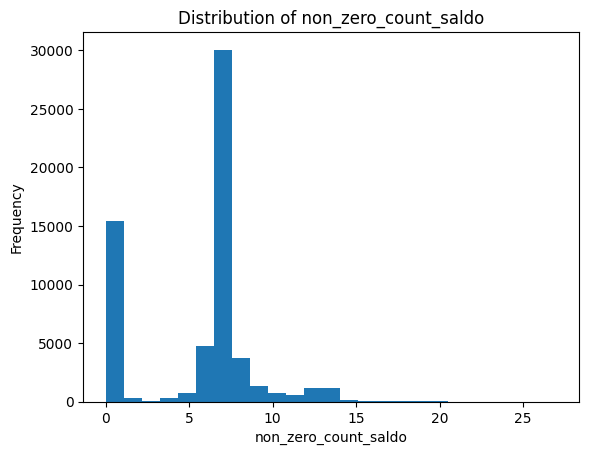

In [14]:
cv.histplot(df, "non_zero_count_saldo", nbins=25)

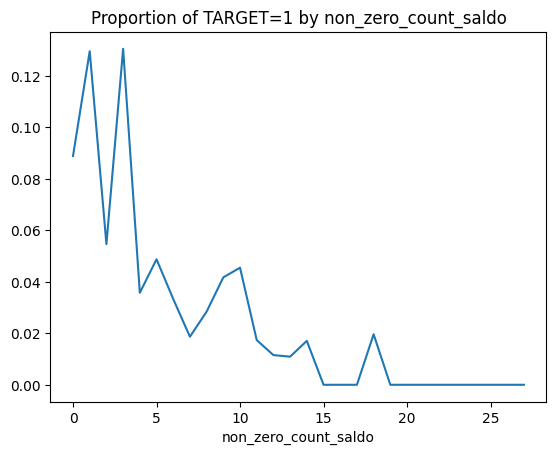

In [15]:
cv.lineplot(df, "non_zero_count_saldo")

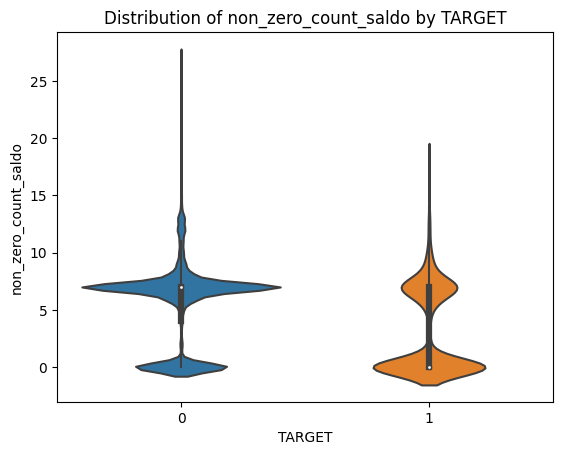

In [16]:
cv.violinplot(df, "non_zero_count_saldo")

##### Soma total das colunas

In [17]:
cs_saldo = CustomSum(prefix="saldo")
cs_saldo = cs_saldo.fit(df)
df = cs_saldo.transform(df)

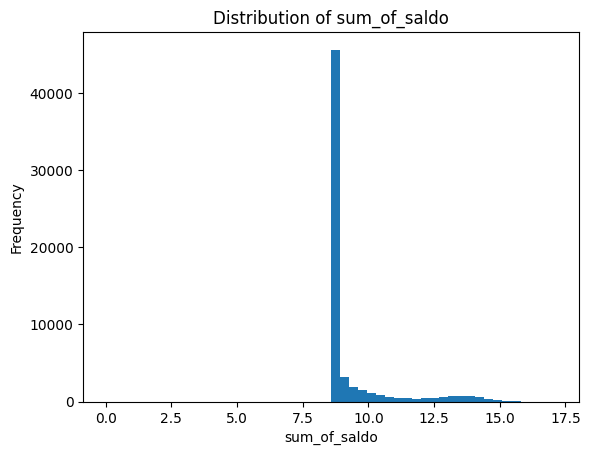

In [18]:
cv.histplot(
    df[["sum_of_saldo"]] \
        .applymap(lambda x:
            np.log(
                x
                - df["sum_of_saldo"].min()
                + 1
        )),
    "sum_of_saldo",
    nbins=50
)

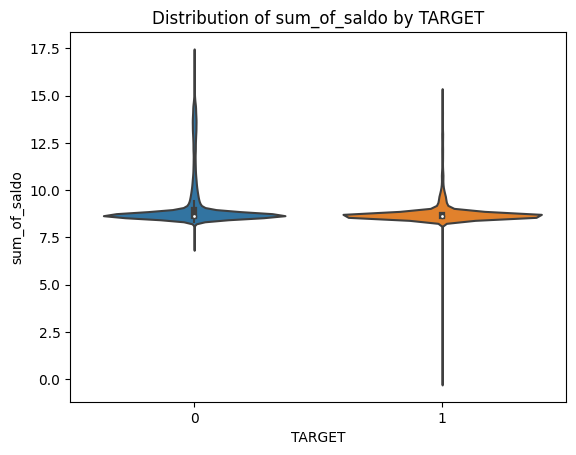

In [19]:
df_ = df.copy()
df_["sum_of_saldo"] = df_["sum_of_saldo"] \
    .apply(lambda x:
        np.log(
            x
            - df_["sum_of_saldo"].min()
            + 1
    ))

cv.violinplot(df_, "sum_of_saldo")

##### Saldo médio por produto

In [20]:
aonzc_saldo = AvgOverNonZero(prefix="saldo")
aonzc_saldo = aonzc_saldo.fit(df)
df = aonzc_saldo.transform(df)

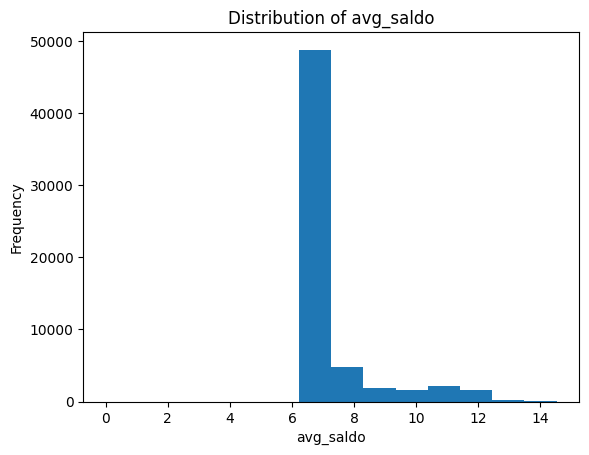

In [21]:
cv.histplot(
    df[["avg_saldo"]] \
        .applymap(lambda x:
            np.log(
                x
                -df["avg_saldo"].min()
                +1)
        ),
    "avg_saldo",
    nbins=14
)

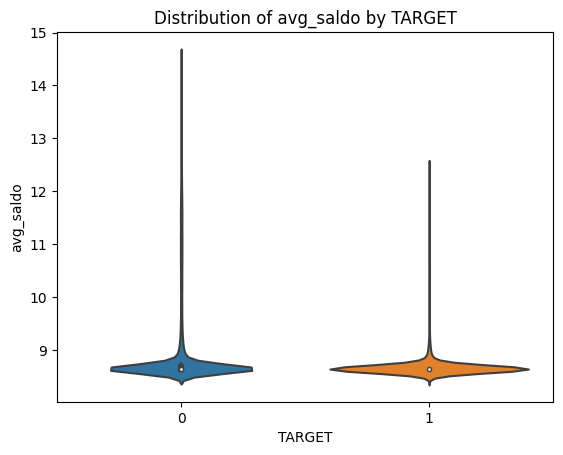

In [22]:
df_ = df.copy()
df_["avg_saldo"] = df_["avg_saldo"] \
    .apply(lambda x:
        np.log(
            x
            + 1
            - df_["sum_of_saldo"].min()
        )
    )
cv.violinplot(df_, "avg_saldo")

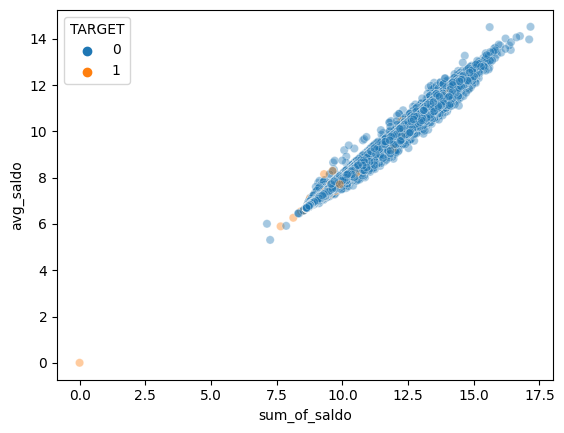

In [23]:
sns.scatterplot(
    x=df["sum_of_saldo"] \
        .apply(lambda x: np.log(x - df["sum_of_saldo"].min() + 1)),
    y=df["avg_saldo"] \
        .apply(lambda x: np.log(x - df["avg_saldo"].min() + 1)),
    hue=df["TARGET"],
    alpha=.4
)
plt.show()

In [24]:
df["avg_saldo"] \
    .apply(lambda x: np.log(x - df["avg_saldo"].min() + 1)) \
    .corr(
        df["sum_of_saldo"] \
            .apply(lambda x: np.log(x - df["sum_of_saldo"].min() + 1))
    )

0.9975217234069733

### Imp

Prefixo "imp": num contexto de mercado financeiro -- entendendo que "Imp" se deriva de "Imposicion", ou seja, algum tipo de taxa --, assumiu-se que estas são variáveis
numéricas. O fato de haver muitos valores únicos em cada coluna, além de valores decimais, reforça esta hipótese.

As caraterísticas deste subconjunto se assemelham muito às do subconjunto de prefixo "saldo". Optou-se por tomar as mesmas decisões, inclusiva a contagem de não-zeros (maior incidência de taxas pode discriminar o comportamento de um cliente?).

Foram criadas as mesmas colunas que no subset de "saldo", com exceção da coluna de saldo médio por produto. Percebeu-se que, aqui, o efeito é o contrário: quanto maior a média de taxas, maior a chance de insatisfação.

#### Verificações generalizadas de "imp"

In [25]:
imp_cols = [
    col
    for col in df.columns
    if col.startswith("imp")
]

df[imp_cols].describe()

,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,imp_amort_var18_ult1,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_ult1,imp_reemb_var17_hace3,imp_reemb_var17_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var17_out_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1
count,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.00000,60816.000000,60816.000000,60816.000000,60816.000000,6.081600e+04,60816.000000,60816.000000,60816.000000,60816.000000,6.081600e+04,60816.000000,6.081600e+04,60816.000000,60816.000000,60816.000000,60816.000000,6.081600e+04,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,6.081600e+04
mean,81.239989,72.185307,119.169036,3.164183,5.748708,0.406672,0.566005,2.919893,69.021124,113.420328,67.706449,111.796809,137.324003,68.113121,112.362815,140.243896,4.13353,0.258021,0.022564,2848.155970,631.587649,1.197763e+02,34.288115,2.484215,0.034530,3.401817,1.480680e+02,11.881684,1.416635e+02,48.352820,0.197763,14.439225,870.980582,1.934909e+03,2.343510,3.140848,2.339529,3.067888,0.173346,0.049329,1.283605,9.881891e+01
std,1364.095864,338.049064,544.262724,86.245545,142.173207,32.490295,38.812040,92.048327,320.203951,514.898002,526.841213,849.182252,700.709527,530.960400,853.740784,715.611960,286.69313,63.630281,4.583333,25562.833133,11407.934951,2.472546e+04,2666.701966,207.221753,4.213975,619.668860,7.036092e+03,936.771518,1.522183e+04,3014.222511,48.770117,1206.329762,13961.760981,2.340013e+04,434.070579,569.043654,399.381114,346.953267,26.398397,12.165006,316.454762,1.260544e+04
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
max,135000

In [26]:
df[imp_cols] \
    .nunique() \
    .sort_values() \
    .reset_index() \
    .rename(
        mapper={
            "index": "Column",
            0: "Number of unique values"
        },
        axis=1
    )

,Column,Number of unique values
0,imp_amort_var18_ult1,2
1,imp_trasp_var33_out_ult1,2
2,imp_reemb_var17_hace3,2
3,imp_venta_var44_hace3,3
4,imp_amort_var34_ult1,3
5,imp_trasp_var17_in_hace3,3
6,imp_trasp_var17_out_ult1,4
7,imp_trasp_var33_in_ult1,4
8,imp_var7_emit_ult1,4
9,imp_trasp_var17_in_ult1,5


In [27]:
neg_pos_zero(df, imp_cols)

,Column,Negative values (%),Positive values (%),Zero values (%)
0,imp_ent_var16_ult1,0,4.760260,95.239740
23,imp_aport_var33_hace3,0,0.027953,99.972047
24,imp_aport_var33_ult1,0,0.008222,99.991778
25,imp_var7_emit_ult1,0,0.004933,99.995067
26,imp_var7_recib_ult1,0,0.281176,99.718824
27,imp_compra_var44_hace3,0,0.037819,99.962181
28,imp_compra_var44_ult1,0,0.116746,99.883254
29,imp_reemb_var13_ult1,0,0.050973,99.949027
30,imp_reemb_var17_hace3,0,0.001644,99.998356
31,imp_reemb_var17_ult1,0,0.024665,99.975335


#### Feature Engineering de "imp"

##### Contagem de colunas diferentes de 0

In [28]:
anzc_imp = AddNonZeroCount(prefix="imp")
anzc_imp = anzc_imp.fit(df)
df = anzc_imp.transform(df)

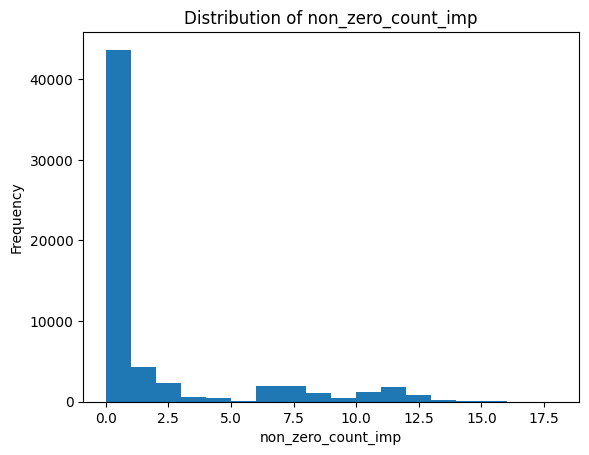

In [29]:
cv.histplot(df, "non_zero_count_imp", nbins=18)

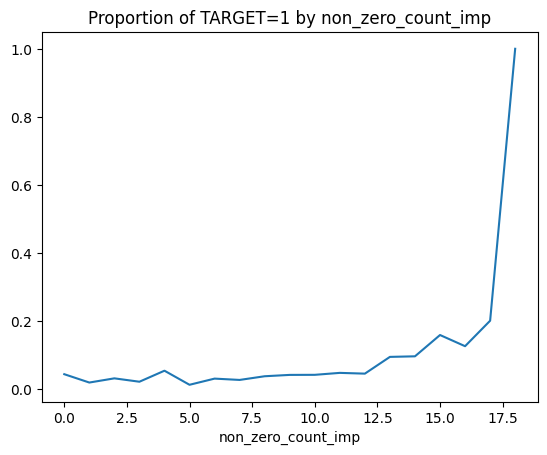

In [30]:
cv.lineplot(df, "non_zero_count_imp")

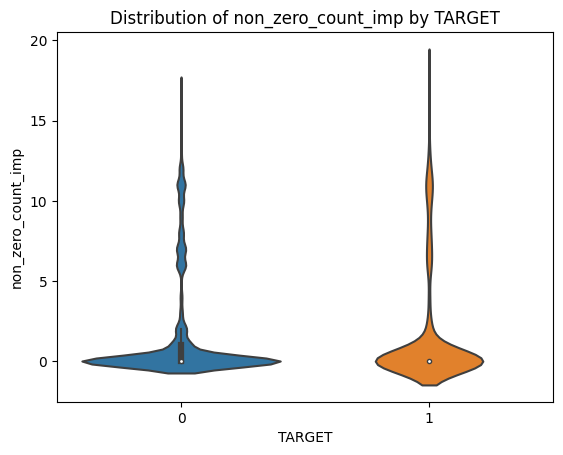

In [31]:
cv.violinplot(df, "non_zero_count_imp")

##### Soma total das colunas

In [32]:
cs_imp = CustomSum(prefix="imp")
cs_imp = cs_imp.fit(df)
df = cs_imp.transform(df)

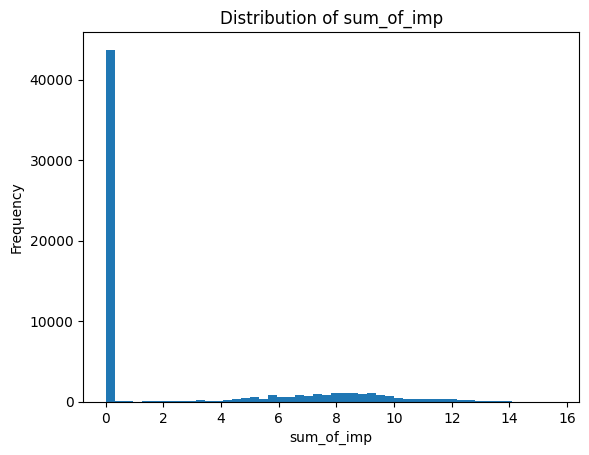

In [33]:
cv.histplot(
    df[["sum_of_imp"]] \
        .applymap(lambda x:
            np.log(
                x
                - df["sum_of_imp"].min()
                + 1
        )),
    "sum_of_imp",
    nbins=50
)

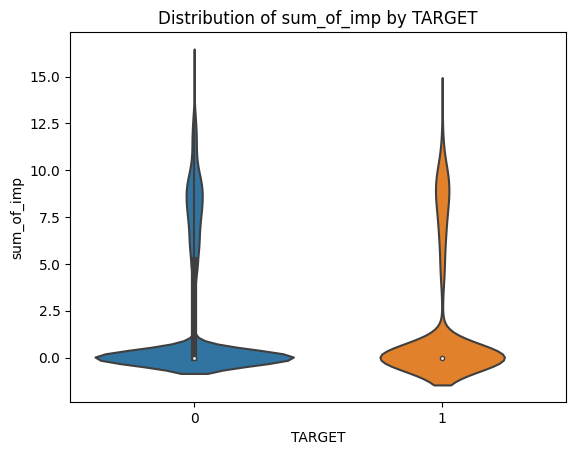

In [34]:
df_ = df.copy()
df_["sum_of_imp"] = df_["sum_of_imp"] \
    .apply(lambda x:
        np.log(
            x
            - df_["sum_of_imp"].min()
            + 1
    ))

cv.violinplot(df_, "sum_of_imp")

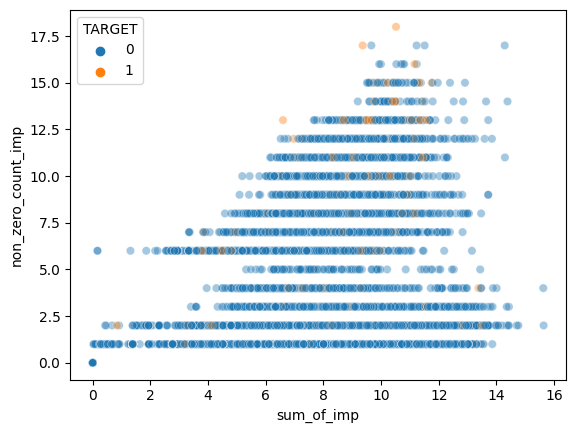

In [35]:
sns.scatterplot(
    x=df["sum_of_imp"] \
        .apply(lambda x: np.log(x - df["sum_of_imp"].min() + 1)),
    y=df["non_zero_count_imp"],
    hue=df["TARGET"],
    alpha=.4
)
plt.show()

### Delta

Prefixo "delta": o nome da coluna sugere que seja algum tipo de variação. Assim, também assumimos que se trata de uma variável numérica. Mesmo que haja poucos valores únicos, aqueles que são diferentes de zero são, em geral, negativos ou decimais.

Diferentemente dos demais subconjuntos estudados até o momento, acredita-se haver valores nulos neste subconjunto, mas que foram preenchidos com 9999999999. Todas as colunas deste subconjunto compartilham este valor como valor máximo, sendo que ao removê-lo o maior valor máximo é de 8.

Um transformador foi criado para contar o número de valores nulos em cada linha, adicionando uma nova variável ao dataset. Em um número muito pequeno de observações esta variável pode acrescentar poder de discriminação ao modelo, mas em geral ela não parece ser muito relevante. De qualquer forma, será mantida no pipeline. O transformador também é capaz de remover features que contenham apenas valores 0 ou nulos após realizar a contagem, mas esta função não foi utilizada pois, como as coluans não foram estudadas caso a caso, não se sabe se haverá perda de informação relevante.

Lembrando que "delta" pode, de fato, significar uma variação, principalmente observando o sufixo das variáveis (1y3) que aparenta indicar um período em que esta variação ocorreu. Valores missing, aqui, podem indicar que o cliente não possuía registros relacionados a estas variáveis no período de comparação, ou seja, sugerindo que é um relacionamento recente com um determinado produto.

Após a contagem de valores nulos, também foi criada a coluna com a contagem de valores diferentes de 0. Nenhuma observação com 1, 2, 4 ou 5 valores diferentes de 0 possui TARGET=1, enquanto as observações com 3 valores diferentes de 0 possuem uma concentração de TARGET=1 quase 10 vezes menor que o total do conjunto.

Por fim, também foi criada a coluna de soma, que mostra que nenhum cliente com soma maior que 0 é insatisfeito e que a concentração de TARGET=1 é menor onde a soma é menor que 0.

#### Verificações generalizadas de "delta"

In [36]:
delta_cols = [
    col
    for col in df.columns
    if col.startswith("delta")
]

df[delta_cols].describe()

,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_venta_var44_1y3
count,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04
mean,1.644304e+05,3.288608e+05,4.817811e+07,5.590634e+06,1.644304e+05,9.701394e+06,5.097343e+06,2.466456e+06,6.577217e+05,4.932912e+05,4.932912e+05,1.644304e+05,6.248356e+06,4.817811e+07,5.590634e+06,1.644304e+05,9.701394e+06,6.248356e+06
std,4.055002e+07,5.734592e+07,6.924362e+08,2.363811e+08,4.055002e+07,3.113221e+08,2.257173e+08,1.570315e+08,8.109804e+07,7.023354e+07,7.023354e+07,4.055002e+07,2.498911e+08,6.924362e+08,2.363811e+08,4.055002e+07,3.113221e+08,2.498911e+08
min,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10


In [37]:
df[delta_cols] \
    .nunique() \
    .sort_values() \
    .reset_index() \
    .rename(
        mapper={
            "index": "Column",
            0: "Number of unique values"
        },
        axis=1
    )

,Column,Number of unique values
0,delta_imp_amort_var18_1y3,2
1,delta_imp_amort_var34_1y3,2
2,delta_imp_trasp_var33_out_1y3,2
3,delta_imp_trasp_var17_out_1y3,2
4,delta_imp_reemb_var13_1y3,2
5,delta_num_aport_var17_1y3,3
6,delta_imp_trasp_var33_in_1y3,3
7,delta_imp_trasp_var17_in_1y3,3
8,delta_imp_reemb_var17_1y3,3
9,delta_imp_aport_var17_1y3,4


In [38]:
df_ = df.copy()
df_[delta_cols] = df_[delta_cols] \
    .applymap(lambda x: None if x == 9999999999 else x)

df_[delta_cols].describe()

,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_venta_var44_1y3
count,60815.0,60814.0,60523.000000,60782.000000,60815.000000,60757.000000,60785.0,60801.000000,60812.000000,60813.0,60813.000000,60815.0,60778.000000,60523.000000,60782.000000,60815.000000,60757.00000,60778.000000
mean,0.0,0.0,-0.021865,-0.000206,-0.000265,-0.000008,0.0,-0.000016,-0.000033,0.0,-0.000082,0.0,0.000073,-0.022091,-0.000230,-0.000222,0.00003,0.000115
std,0.0,0.0,0.151406,0.016350,0.015977,0.035928,0.0,0.004056,0.005735,0.0,0.009067,0.0,0.022345,0.147205,0.015175,0.014759,0.02945,0.032703
min,0.0,0.0,-1.000000,-1.000000,-1.000000,-1.000000,0.0,-1.000000,-1.000000,0.0,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000
25%,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,0.0,0.0,5.500000,1.500000,0.000000,6.267608,0.0,0.000000,0.000000,0.0,0.000000,0.0,5.417098,1.000000,0.000000,0.000000,4.00000,8.000000


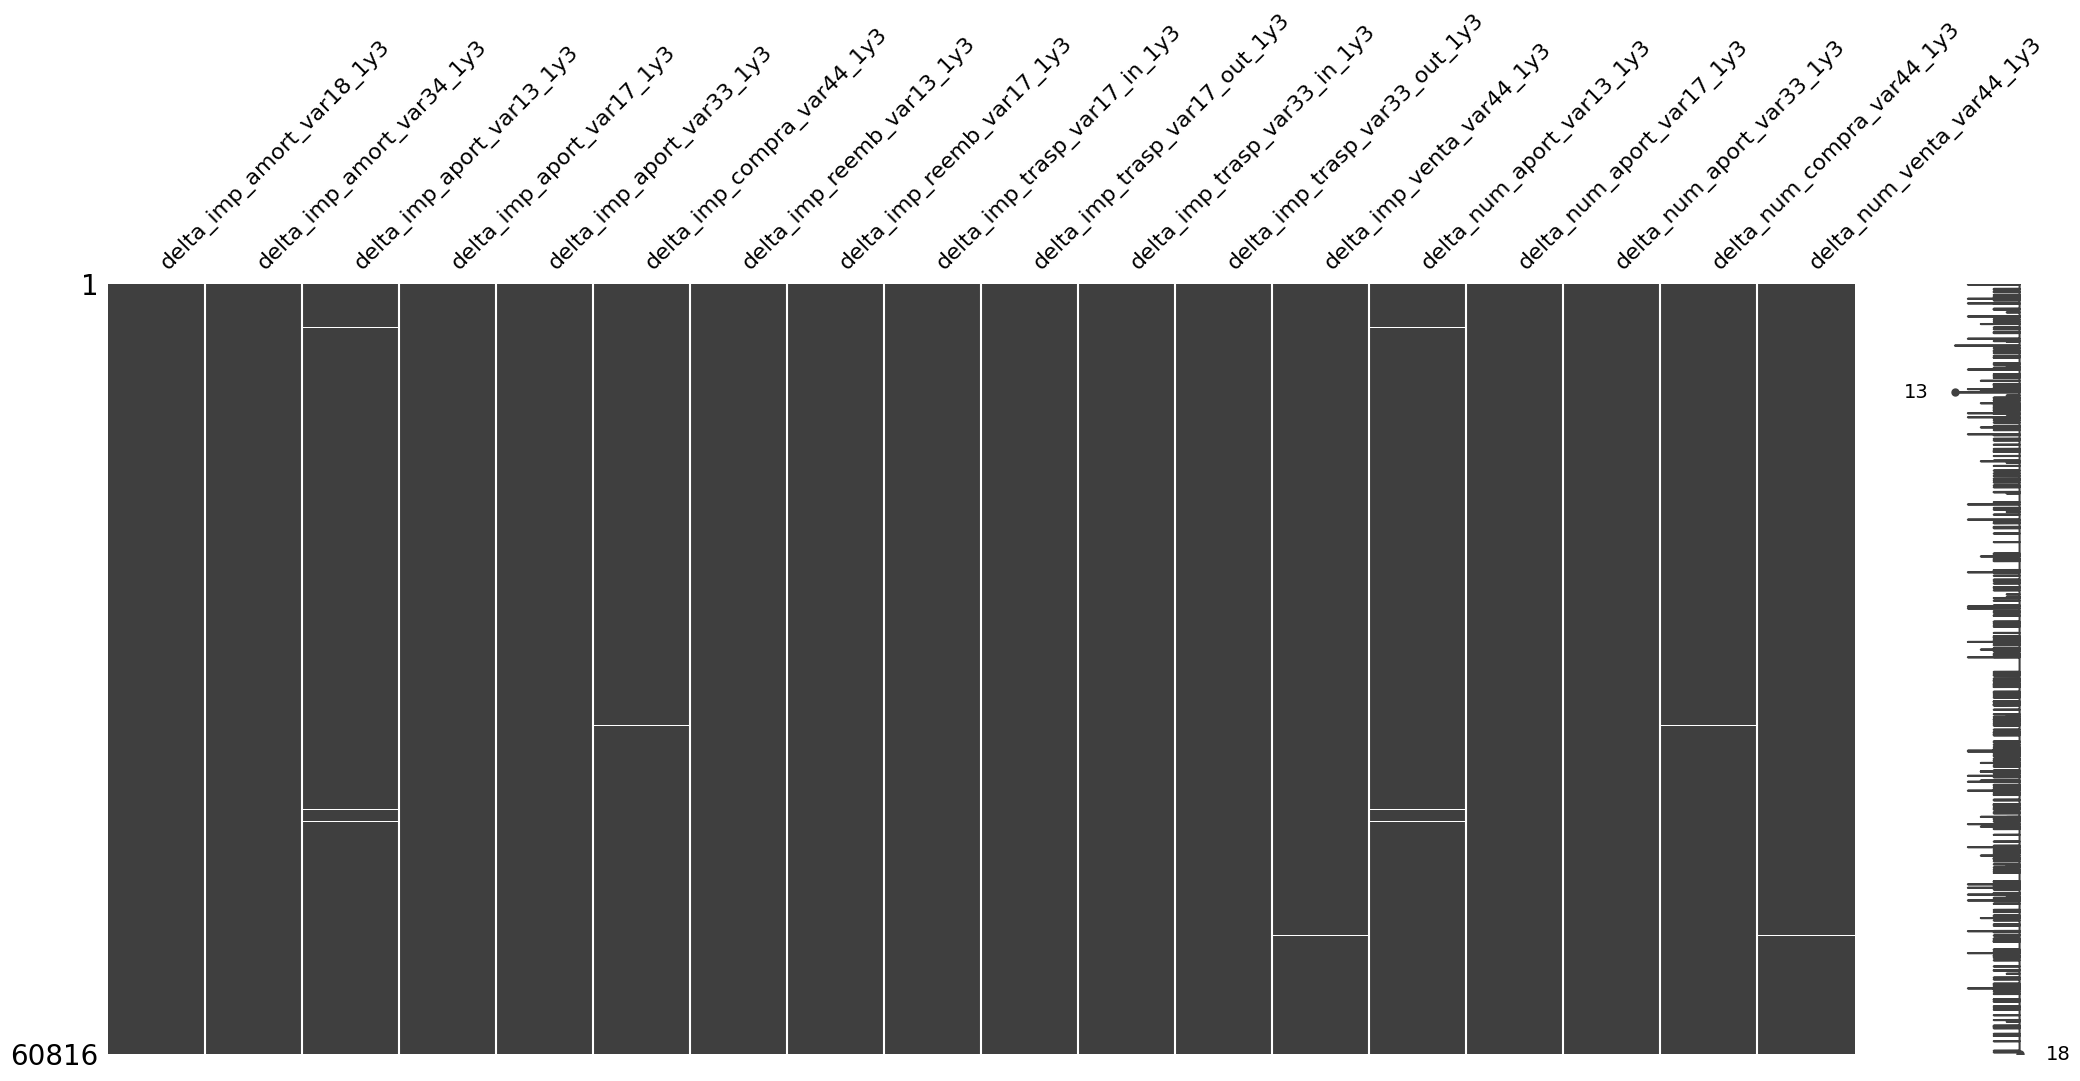

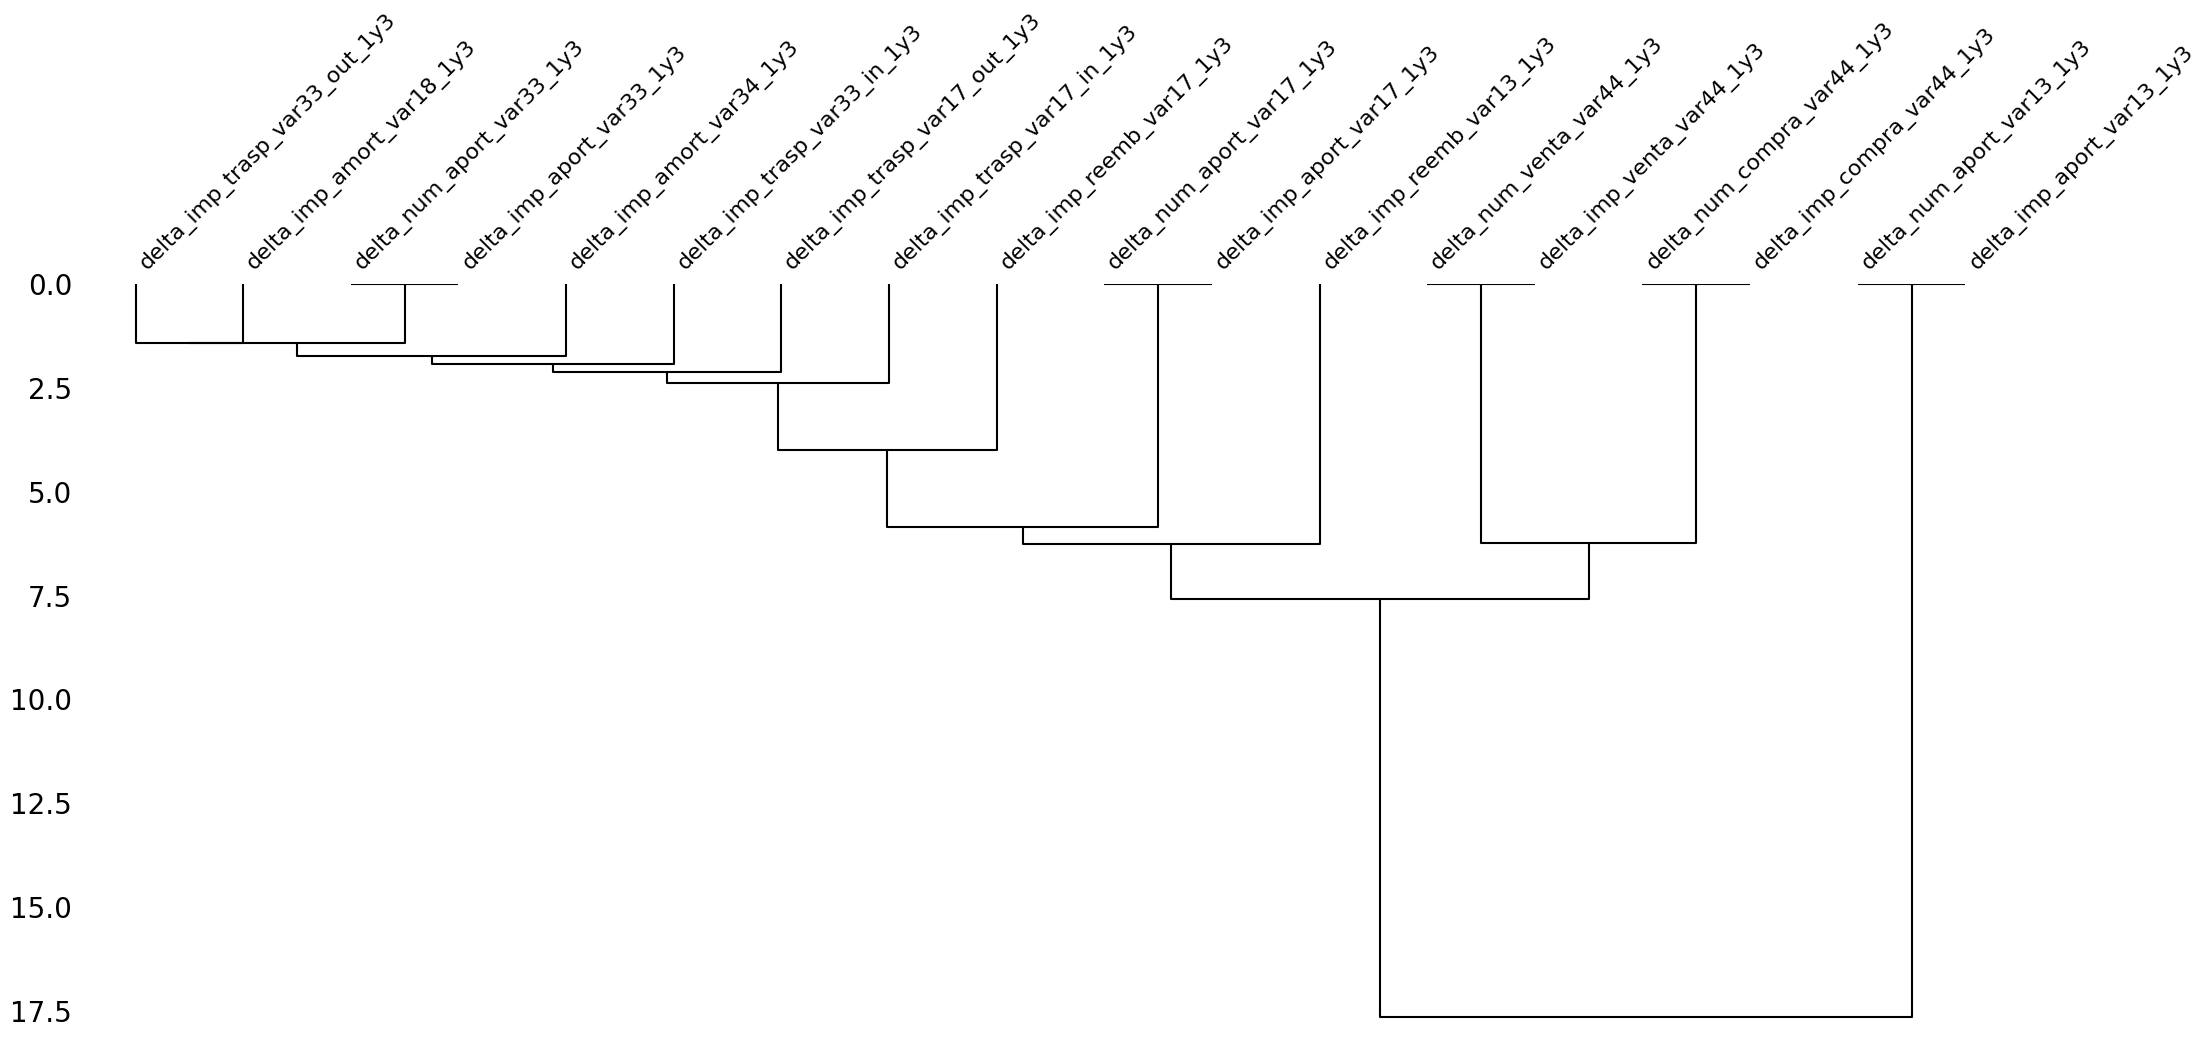

In [39]:
mno.matrix(df_[delta_cols])
plt.show()
mno.dendrogram(df_[delta_cols])
plt.show()

#### Feature Engineering de "delta"

##### Contagem de nulos

In [40]:
anc_delta = AddNoneCount(prefix="delta", fake_value=9999999999)
anc_delta = anc_delta.fit(df)
df = anc_delta.transform(df)

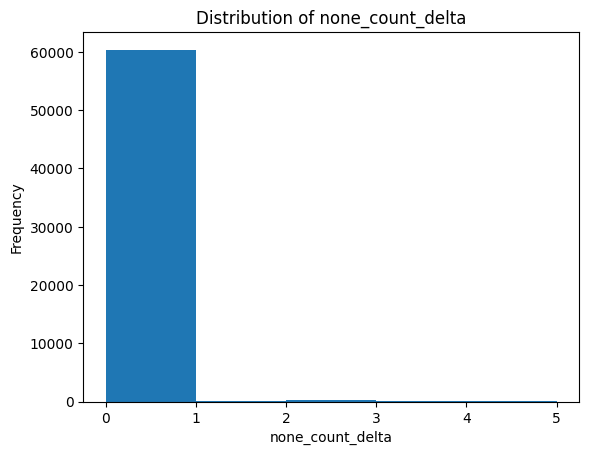

In [41]:
cv.histplot(df, "none_count_delta", nbins=5)

In [42]:
df["none_count_delta"].value_counts()

none_count_delta
0    60387
2      348
1       32
4       31
3       16
5        2
Name: count, dtype: int64

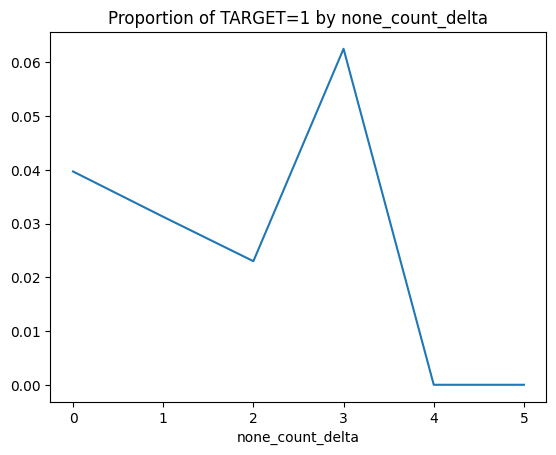

In [43]:
cv.lineplot(df, "none_count_delta")

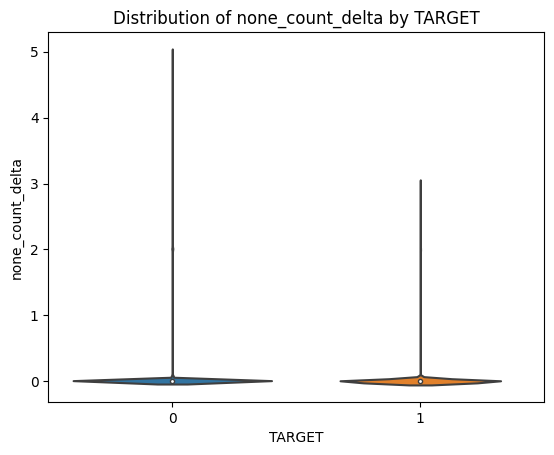

In [44]:
cv.violinplot(df, "none_count_delta")

##### Contagem de colunas diferentes de 0

In [45]:
anzc_delta = AddNonZeroCount(prefix="delta", fake_value=9999999999)
anzc_delta = anzc_delta.fit(df)
df = anzc_delta.transform(df)

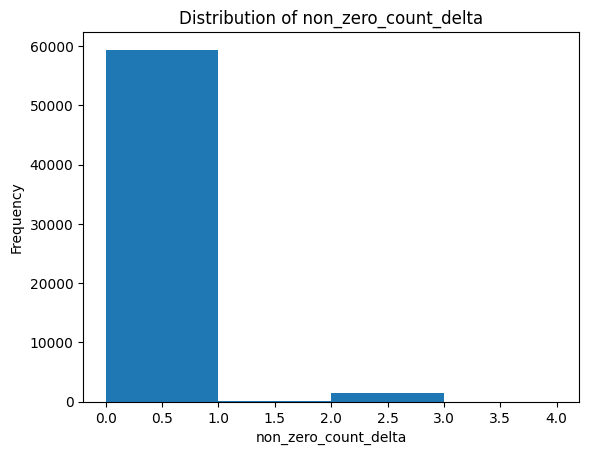

In [46]:
cv.histplot(df, "non_zero_count_delta", nbins=4)

In [47]:
df["non_zero_count_delta"].value_counts()

non_zero_count_delta
0    59402
2     1374
1       29
3        6
4        5
Name: count, dtype: int64

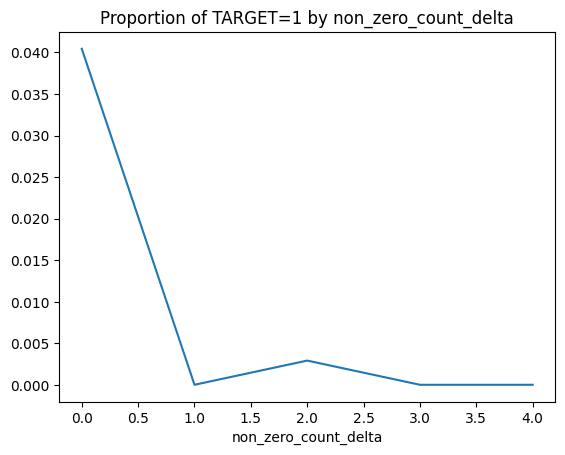

In [48]:
cv.lineplot(df, "non_zero_count_delta")

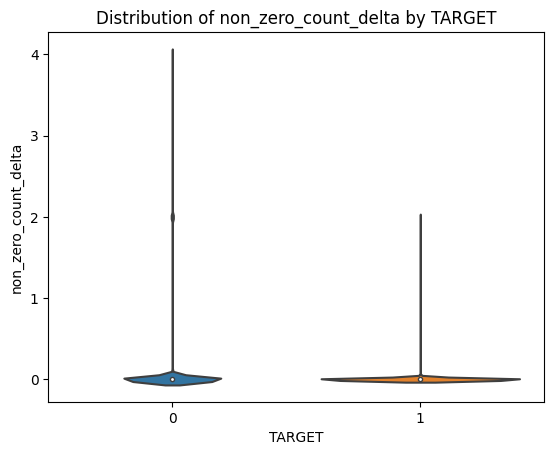

In [49]:
cv.violinplot(df, "non_zero_count_delta")

##### Soma total das colunas

In [50]:
cs_delta = CustomSum(prefix="delta", fake_value=9999999999)
cs_delta = cs_delta.fit(df)
df = cs_delta.transform(df)

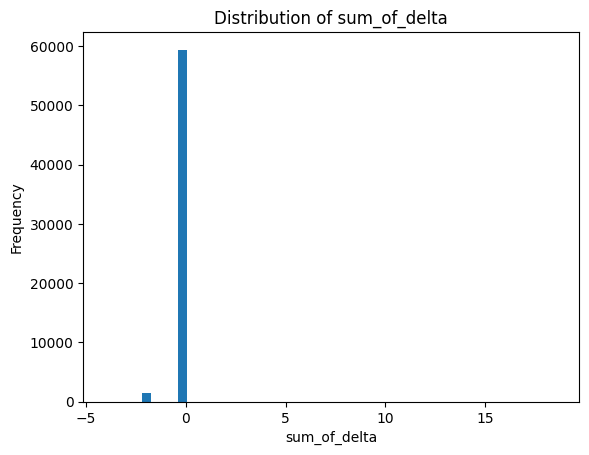

In [51]:
cv.histplot(df,"sum_of_delta", nbins=50)

In [52]:
df["TARGET"] \
    .value_counts(normalize=True) \
    .reset_index() \
        .merge(
            df \
                [df["sum_of_delta"]<0] \
                ["TARGET"] \
                .value_counts(normalize=True) \
                .reset_index(),
            how="left",
            on="TARGET",
            suffixes=("", "_less_than_zero")
        ) \
        .merge(
            df \
                [df["sum_of_delta"]!=0] \
                ["TARGET"] \
                .value_counts(normalize=True) \
                .reset_index(),
            how="left",
            on="TARGET",
            suffixes=("", "_not_zero")
        ) \
        .merge(
            df \
                [df["sum_of_delta"]>0] \
                ["TARGET"] \
                .value_counts(normalize=True) \
                .reset_index(),
            how="left",
            on="TARGET",
            suffixes=("", "_greater_than_zero")
        )

,TARGET,proportion,proportion_less_than_zero,proportion_not_zero,proportion_greater_than_zero
0,0,0.960438,0.997137,0.997171,1.0
1,1,0.039562,0.002863,0.002829,NaN


### Ind

Prefixo "ind": estas variáveis são compostas exclusivamente por valores de 0 e 1, ou seja, são variáveis binárias.

Neste caso, como as variáveis já são binarizadas, a análise é mais simples. Não há nenhum outlier que chame a atenção ou levante suspeitas de serem, na verdade, missing features.

Foi criada a coluna de contagem de valores diferentes de zero. Desta vez, o plot de concentração de TARGET=1 por contagem de não-zeros é muito poluído, mostrando que esta variável não deve ter bom poder de discriminação.

In [53]:
ind_cols = [
    col
    for col in df.columns
    if col.startswith("ind")
]

df[ind_cols].describe().loc[["min", "max"]]

,ind_var1_0,ind_var1,ind_var5_0,ind_var5,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_cte,ind_var26,ind_var25,ind_var29_0,ind_var29,ind_var30_0,ind_var30,ind_var31_0,ind_var31,ind_var32_cte,ind_var32,ind_var33_0,ind_var33,ind_var34,ind_var37_cte,ind_var37,ind_var39_0,ind_var40_0,ind_var41_0,ind_var39,ind_var44_0,ind_var44,ind_var7_emit_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10cte_ult1,ind_var9_cte_ult1,ind_var9_ult1,ind_var43_emit_ult1,ind_var43_recib_ult1
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [54]:
df[ind_cols] \
    .nunique() \
    .nlargest(10) \
    .reset_index() \
    .rename(
        mapper={
            "index": "Column",
            0: "Number of unique values"
        },
        axis=1
    )

,Column,Number of unique values
0,ind_var1_0,2
1,ind_var1,2
2,ind_var5_0,2
3,ind_var5,2
4,ind_var8_0,2
5,ind_var8,2
6,ind_var12_0,2
7,ind_var12,2
8,ind_var13_0,2
9,ind_var13_corto_0,2


In [55]:
anzc_ind = AddNonZeroCount(prefix="ind")
anzc_ind = anzc_ind.fit(df)
df = anzc_ind.transform(df)

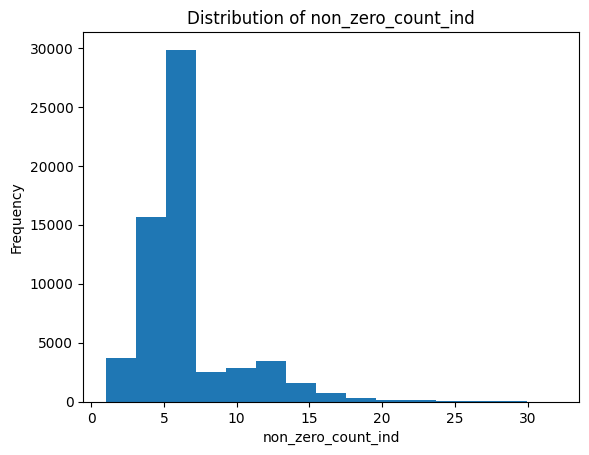

In [56]:
cv.histplot(df, "non_zero_count_ind", nbins=15)

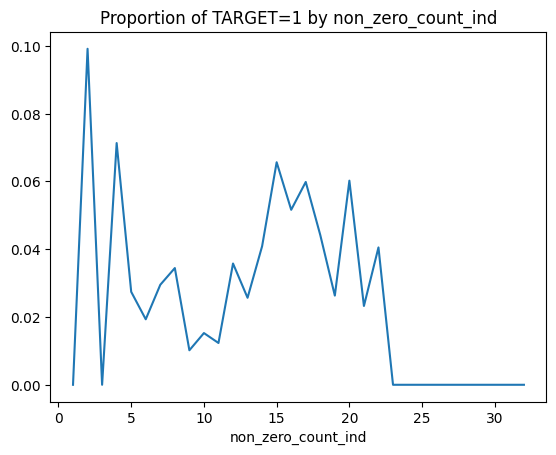

In [57]:
cv.lineplot(df, "non_zero_count_ind")

In [58]:
df[df["non_zero_count_ind"]>=24]["non_zero_count_ind"].count()

55

### Num

Prefixo "Num": o prefixo indica que as variáveis sejam uma contagem ("número de vendas", "número de recibos"). O fato de não haver nenhum valor negativo nem nenhum número decimal corrobora com esta ideia.

Assumiu-se que se tratam de variáveis de contagem e, para esta EDA, optou-se por não realizar qualquer alteração. Também não há um valor exorbitante comum entre as colunas, indicando que estes dados não tiveram valores faltantes preenchidos artificialmente.

Assim como no caso de "ind", a contagem de não-zeros não parece ser uma boa variável para discriminar a insatisfação, mas foi mantida mesmo assim, pois não sabemos se junto às demais variáveis ela pode ser útil. Por outro lado, a variável de soma mostra que, quanto maior seu valor, maior a probabilidade de insatisfação. O gráfico de violino, especialmente, mostra como a distribuição desta variável é diferente entre os dois grupos (TARGET=0 e TARGET=1)

#### Verificações generalizadas de "num"

In [59]:
num_cols = [
    col
    for col in df.columns
    if col.startswith("num")
]

df[num_cols].describe()

,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var18,num_var20_0,num_var20,num_var24_0,num_var24,num_var26,num_var25,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var29_0,num_var29,num_var30_0,num_var30,num_var31_0,num_var31,num_var32,num_var33_0,num_var33,num_var34,num_var35,num_var37_med_ult2,num_var37,num_var39_0,num_var40_0,num_var41_0,num_var39,num_var42_0,num_var42,num_var44_0,num_var44,num_aport_var13_hace3,num_aport_var13_ult1,num_aport_var17_hace3,num_aport_var17_ult1,num_aport_var33_hace3,num_aport_var33_ult1,num_var7_emit_ult1,num_var7_recib_ult1,num_compra_var44_hace3,num_compra_var44_ult1,num_ent_var16_ult1,num_var22_hace2,num_var22_hace3,num_var22_ult1,num_var22_ult3,num_med_var22_ult3,num_med_var45_ult3,num_meses_var5_ult3,num_meses_var8_ult3,num_meses_var12_ult3,num_meses_var13_corto_ult3,num_meses_var13_largo_ult3,num_meses_var17_ult3,num_meses_var29_ult3,num_meses_var33_ult3,num_meses_var39_vig_ult3,num_meses_var44_ult3,num_op_var39_comer_ult1,num_op_var39_comer_ult3,num_op_var40_comer_ult1,num_op_var40_comer_ult3,num_op_var40_efect_ult1,num_op_var40_efect_ult3,num_op_var41_comer_ult1,num_op_var41_comer_ult3,num_op_var41_efect_ult1,num_op_var41_efect_ult3,num_op_var39_efect_ult1,num_op_var39_efect_ult3,num_reemb_var13_ult1,num_reemb_var17_hace3,num_reemb_var17_ult1,num_sal_var16_ult1,num_var43_emit_ult1,num_var43_recib_ult1,num_trasp_var11_ult1,num_trasp_var17_in_hace3,num_trasp_var17_in_ult1,num_trasp_var17_out_ult1,num_trasp_var33_in_hace3,num_trasp_var33_in_ult1,num_trasp_var33_out_ult1,num_venta_var44_hace3,num_venta_var44_ult1,num_var45_hace2,num_var45_hace3,num_var45_ult1,num_var45_ult3
count,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000
mean,0.033445,0.010754,1.080620,2.895570,1.999852,0.098856,0.085685,0.211770,0.138664,0.167719,0.129834,0.124260,0.037885,0.035764,0.160024,0.072563,0.016081,0.012727,0.009521,0.000049,0.010359,0.007449,0.128848,0.115134,0.089532,0.085635,0.020472,0.001135,0.054953,0.076559,1.618587,0.092443,2.875444,4.586474,1.639059,0.093577,2.930397,4.663033,0.000395,0.000099,3.374309,2.384323,0.020768,0.016476,0.003897,0.002269,0.001776,0.000099,3.302733,0.265341,0.420827,2.723954

In [60]:
df[num_cols] \
    .nunique() \
    .nlargest(10) \
    .reset_index() \
    .rename(
        mapper={
            "index": "Column",
            0: "Number of unique values"
        },
        axis=1
    )

,Column,Number of unique values
0,num_var45_ult3,160
1,num_op_var39_ult3,96
2,num_op_var41_ult3,93
3,num_op_var39_comer_ult3,89
4,num_var45_ult1,89
5,num_op_var41_comer_ult3,86
6,num_var45_hace2,80
7,num_op_var39_ult1,67
8,num_med_var45_ult3,66
9,num_op_var41_ult1,64


In [61]:
nfloat = df[num_cols].applymap(lambda x: 0 if x%1 == 0 else 1).sum().sum()
print(f"Contagem de números decimais: {nfloat}")

Contagem de números decimais: 0


#### Feature Engineering de "num"

##### Contagem de colunas diferentes de 0

In [62]:
anzc_num = AddNonZeroCount(prefix="num")
anzc_num = anzc_num.fit(df)
df = anzc_num.transform(df)

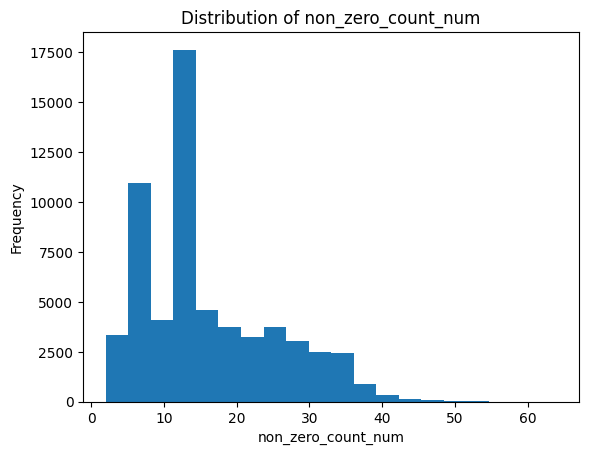

In [63]:
cv.histplot(df, "non_zero_count_num", nbins=20)

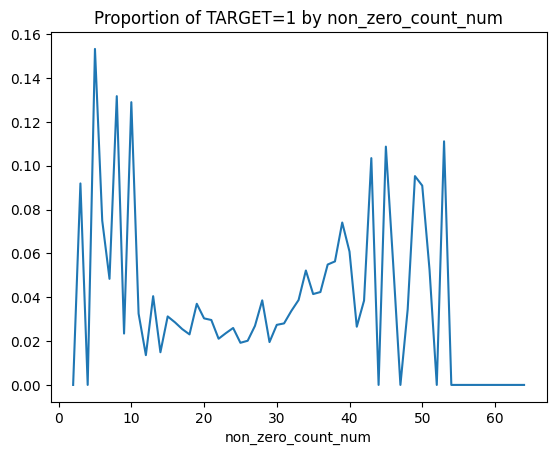

In [64]:
cv.lineplot(df, "non_zero_count_num")

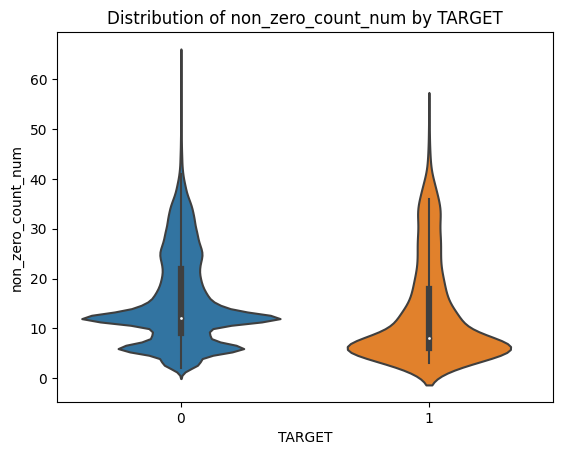

In [65]:
cv.violinplot(df, "non_zero_count_num")

##### Soma total das colunas

In [66]:
cs_num = CustomSum(prefix="num")
cs_num = cs_num.fit(df)
df = cs_num.transform(df)

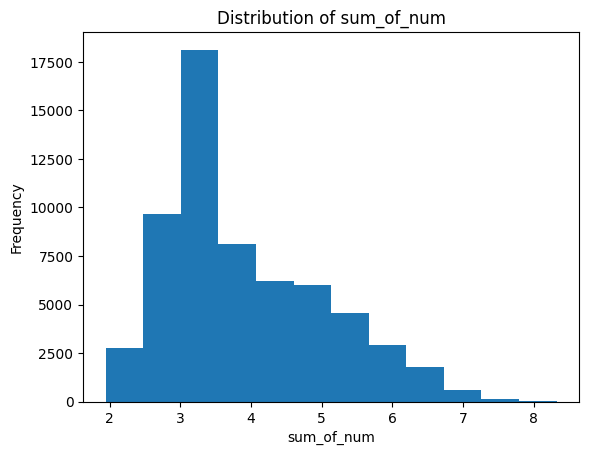

In [67]:
cv.histplot(
    df[["sum_of_num"]].applymap(lambda x: np.log(x+1)),
    "sum_of_num",
    nbins=12)

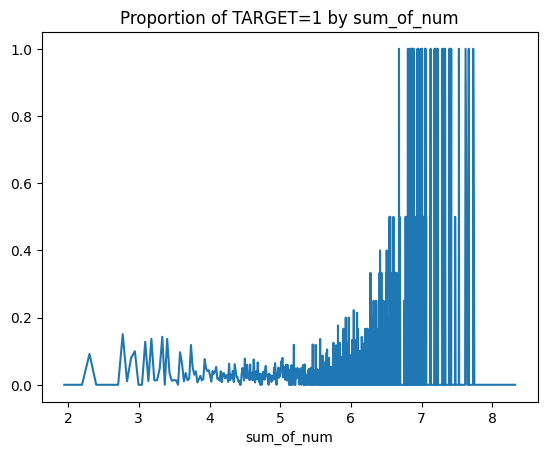

In [68]:
df_ = df.copy()
df_["sum_of_num"] = df_["sum_of_num"] \
    .apply(lambda x: np.log(x+1))

cv.lineplot(df_, "sum_of_num")

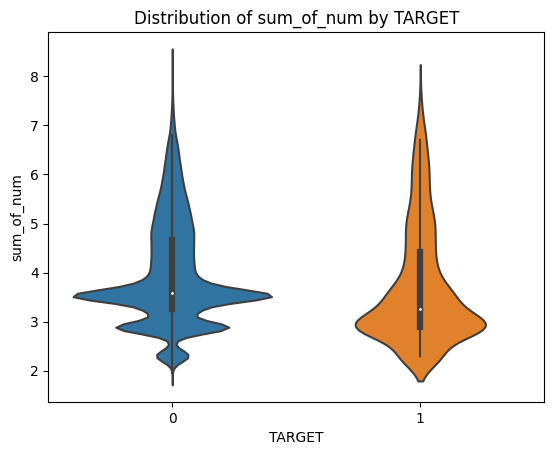

In [69]:
cv.violinplot(df_, "sum_of_num")

### Demais variáveis

Por fim, foram encontradas variáveis sem prefixos. Como são poucas variáveis, optou-se por tratá-las uma a uma, pois sem prefixo não podemos assumir que se tratam de grandezas semelhantes nem que são do mesmo tipo (contínua, discreta, categórica, etc).

O ideal seria abordar todas as variáveis desta forma e, inclusive, tentar relacionar variáveis de diferentes prefixos com base em seus nomes, pois aparentemente estas podem estar relacionadas (uma variável "ind" pode ser uma flag de uma variável "saldo", por exemplo).

#### Verificações generalizadas de demais variáveis

In [70]:
remaining_cols = [
    col
    for col in df.columns
    if (
        (col not in imp_cols)
        & (col not in ind_cols)
        & (col not in num_cols)
        & (col not in saldo_cols)
        & (col not in delta_cols)
        & ("count" not in col)
        & ("sum" not in col)
        & ("avg" not in col)
        & (col not in ["TARGET", "ID"])
    )
]

In [71]:
df[remaining_cols].describe()

,var3,var15,var36,var21,var38
count,60816.000000,60816.000000,60816.000000,60816.000000,6.081600e+04
mean,-1526.496991,33.218742,40.507054,31.871547,1.176408e+05
std,39075.501176,12.947363,47.375790,393.703492,1.895319e+05
min,-999999.000000,5.000000,0.000000,0.000000,5.163750e+03
25%,2.000000,23.000000,2.000000,0.000000,6.777529e+04
50%,2.000000,28.000000,3.000000,0.000000,1.065147e+05
75%,2.000000,40.000000,99.000000,0.000000,1.187928e+05
max,238.000000,105.000000,99.000000,30000.000000,2.203474e+07


In [72]:
df[remaining_cols] \
    .nunique() \
    .reset_index() \
    .rename(
        mapper={
            "index": "Column",
            0: "Number of unique values"
        },
        axis=1
    )

,Column,Number of unique values
0,var3,192
1,var15,100
2,var36,5
3,var21,22
4,var38,46671


#### var3

Esta variável possui 192 valores únicos, incluindo um único valor negativo de -999999 que se repete 93 vezes. Não há números decimais, apenas inteiros. Assume-se que é uma variável de contagem. Os valores de -999999 não foram tratados apesar de aparentarem nulos (assim como no caso das variáveis delta), pois a princípio usaremos modelos de árvore que, por sua vez, não são sensíveis à relação não linear entre as variáveis preditoras e a variável de interesse. Percebeu-se que em alguns casos onde esta variável é maior, há maior concentração de TARGET=1. Onde a variável é nula, TARGET=1 é menos frequente. 

In [73]:
var = "var3"

nfloat = df[var].apply(lambda x: 0 if x%1 == 0 else 1).sum()
print(f"Contagem de números decimais: {nfloat}")

Contagem de números decimais: 0


In [74]:
df[df[var]<0][var].value_counts()

var3
-999999    93
Name: count, dtype: int64

In [75]:
df["TARGET"] \
    .value_counts(normalize=True) \
    .reset_index() \
        .merge(
            df \
                [df["var3"]<0] \
                ["TARGET"] \
                .value_counts(normalize=True) \
                .reset_index(),
            how="left",
            on="TARGET",
            suffixes=("", "_less_than_zero")
        ) \
        .merge(
            df \
                [df["var3"]!=0] \
                ["TARGET"] \
                .value_counts(normalize=True) \
                .reset_index(),
            how="left",
            on="TARGET",
            suffixes=("", "_not_zero")
        ) \
        .merge(
            df \
                [df["var3"]>0] \
                ["TARGET"] \
                .value_counts(normalize=True) \
                .reset_index(),
            how="left",
            on="TARGET",
            suffixes=("", "_greater_than_zero")
        )

,TARGET,proportion,proportion_less_than_zero,proportion_not_zero,proportion_greater_than_zero
0,0,0.960438,0.978495,0.960478,0.96045
1,1,0.039562,0.021505,0.039522,0.03955


In [76]:
df[(df[var]<0) & (df[var] != -999999)][var].count()

0

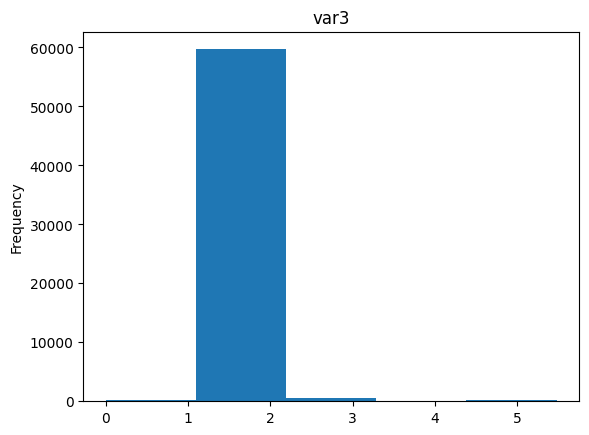

In [77]:
df_ = df.copy()
df_[var] = df_[var] \
    .apply(lambda x: None if x == -999999 else np.log(x+1))

df_[var]\
    .plot \
    .hist(bins=5)
plt.title(var)
plt.show()


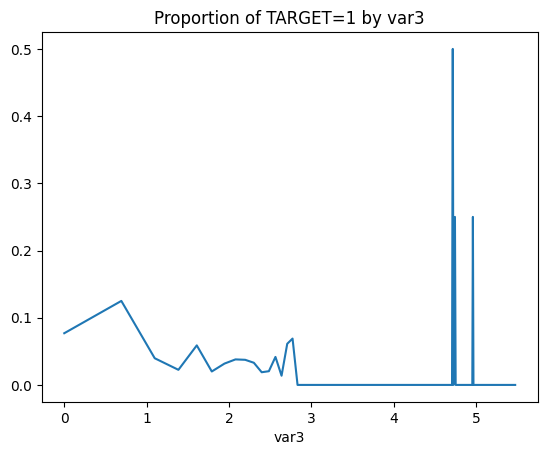

In [78]:
cv.lineplot(df_, var)

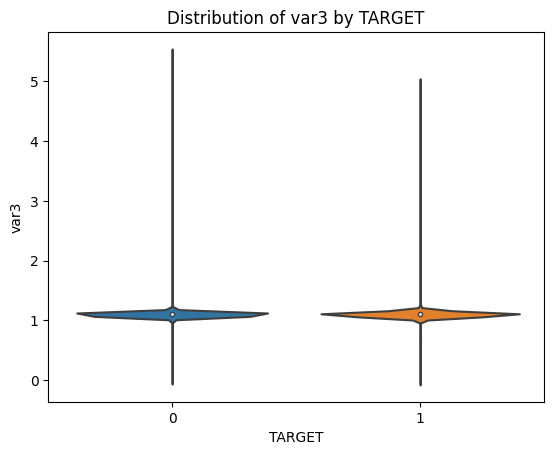

In [79]:
cv.violinplot(df_, var)

In [80]:
df_ = df.copy()
df_["null"] = df_[var].apply(lambda x: 1 if x == -999999 else 0)

df_ \
    .groupby("null")["TARGET"] \
    .value_counts(normalize=True) \
    .unstack()

TARGET,0,1
null,,
0,0.960410,0.039590
1,0.978495,0.021505


#### var15

Esta variável possui 100 valores únicos entre 5 e 105. Não há valores decimais. Todas estas características levam a acreditar que esta variável se trata da idade do cliente -- o que faz algum sentido, dada a escassez de clientes menores de 18 anos, que provavelmente é resultado de alguma política do banco. Assumiu-se que é uma variável numérica, sem necessidade de qualquer outro tratamento.

In [81]:
var = "var15"

nfloat = df[var].apply(lambda x: 0 if x%1 == 0 else 1).sum()
print(f"Contagem de números decimais: {nfloat}")

Contagem de números decimais: 0


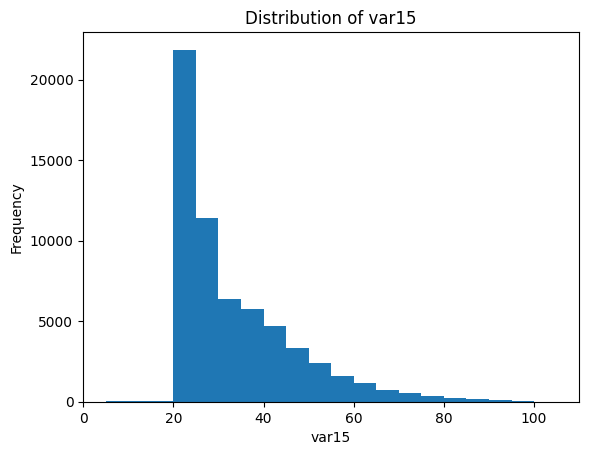

In [83]:
cv.histplot(df, var, nbins=20)

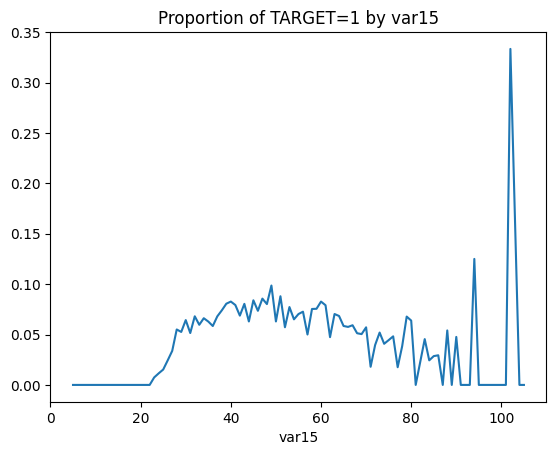

In [82]:
cv.lineplot(df, var)

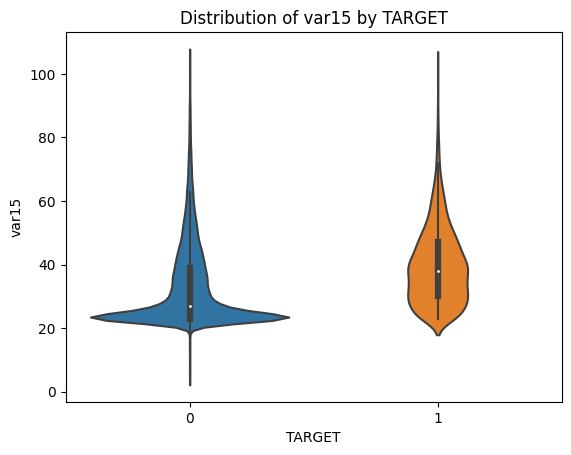

In [84]:
cv.violinplot(df, var)

#### var36

Esta variável aparenta ser uma variável categórica com labels não ordinais. Para os modelos de classificação baseados em árvore, será interessante aplicar um Ordinal Encoder para que as categorias sejam ordenadas com base na incidência de 1 na variável de interesse. Já para modelos lineares e análise de cluster, One Hot Encoding ou Weight of Evidence podem ser mais interessantes. O valor 99 aparenta ser artificial, mas será considerado como uma categoria por ser muito representativo.

In [85]:
var = "var36"

nfloat = df[var].apply(lambda x: 0 if x%1 == 0 else 1).sum()
print(f"Contagem de números decimais: {nfloat}")

Contagem de números decimais: 0


In [86]:
df[var].value_counts()

var36
99    24088
3     17691
1     11728
2      6982
0       327
Name: count, dtype: int64

In [91]:
df \
    .groupby(var)["TARGET"] \
    .value_counts(normalize=True) \
    .unstack() \
    .sort_values(by=0, ascending=False)

TARGET,0,1
var36,,
0,1.000000,NaN
3,0.983607,0.016393
2,0.970066,0.029934
1,0.968366,0.031634
99,0.936234,0.063766


#### var21

Outra variável que aparenta ser categórica com labels não ordinais. O mesmo tratamento de var36 será aplicado nos modelos.

In [92]:
var = "var21"

nfloat = df[var].apply(lambda x: 0 if x%1 == 0 else 1).sum()
print(f"Contagem de números decimais: {nfloat}")

Contagem de números decimais: 0


In [98]:
df_ = df \
    .groupby(var)["TARGET"] \
    .value_counts(normalize=True) \
    .unstack()

df_["count"] = df[var] \
    .value_counts()

df_.sort_values(by=0, ascending=False)

TARGET,0,1,count
var21,,,
30000,1.000000,NaN,1
6000,1.000000,NaN,21
1200,1.000000,NaN,8
1500,1.000000,NaN,24
18000,1.000000,NaN,2
10500,1.000000,NaN,1
2400,1.000000,NaN,3
2700,1.000000,NaN,23
9000,1.000000,NaN,10


#### var38
Já esta variável aparenta ser numérica, dada a grande quantidade de valores únicos e presença majoritária de números decimais.

In [99]:
var = "var38"

nfloat = df[var].apply(lambda x: 0 if x%1 == 0 else 1).sum()
print(f"Contagem de números decimais: {nfloat}")

Contagem de números decimais: 60257


In [101]:
df[[var]].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
var38,60816.0,117640.846586,189531.908253,5163.75,67775.2875,106514.73,118792.8225,22034738.76


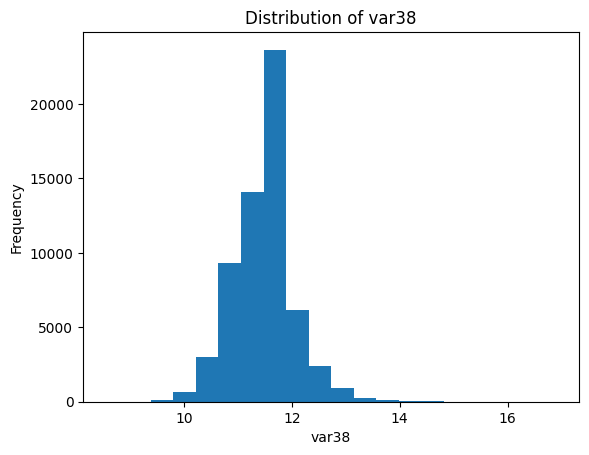

In [103]:
df_ = df.copy()
df_[var] = df_[var].apply(lambda x: np.log(x+1))

cv.histplot(df_, var, nbins=20)

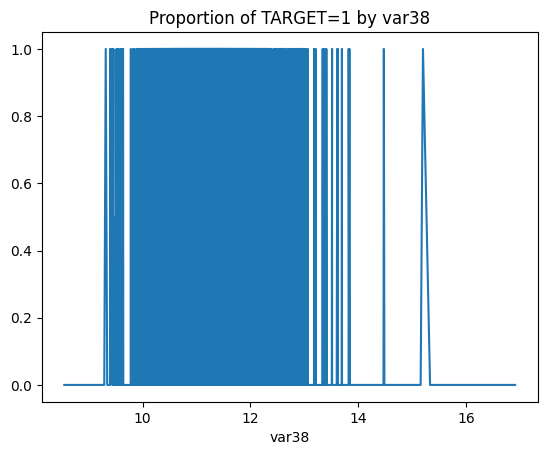

In [104]:
cv.lineplot(df_, var)

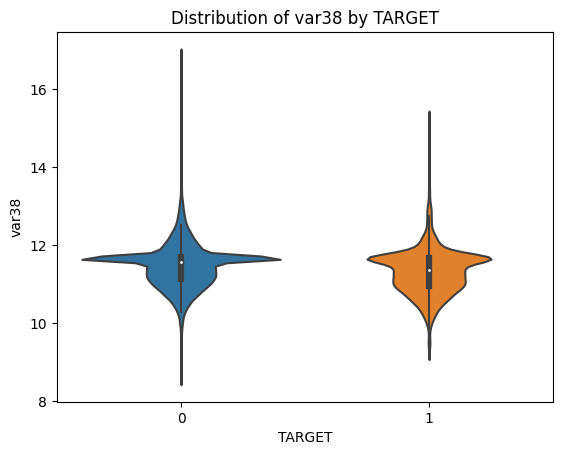

In [105]:
cv.violinplot(df_, var)